In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_palette("Set2")
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder

# 1. EDA

In [2]:
df = pd.read_csv('./datasets/forestfires.csv')

In [3]:
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [98]:
print(f'          Number of rows: {df.shape[0]}')
print(f'      Number of features: {df.shape[1]}')
print(f'Number of missing values: {df.isna().sum().sum()}')
print(f'    Number of duplicates: {df.duplicated().sum()}')

          Number of rows: 517
      Number of features: 13
Number of missing values: 0
    Number of duplicates: 4


We will drop the duplicates since it is unknown why they exist.

In [99]:
df.drop_duplicates(keep='first', inplace=True)

In [100]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
X,513.0,4.678363,2.320059,1.0,3.0,4.00,7.00,9.00
Y,513.0,4.300195,1.230925,2.0,4.0,4.00,5.00,9.00
FFMC,513.0,90.637427,5.540920,18.7,90.2,91.60,92.90,96.20
DMC,513.0,110.989279,64.191013,1.1,68.6,108.30,142.40,291.30
DC,513.0,549.155166,247.724594,7.9,440.9,664.50,713.90,860.60
ISI,513.0,9.023587,4.575543,0.0,6.4,8.40,11.00,56.10
temp,513.0,18.887524,5.828128,2.2,15.5,19.30,22.80,33.30
RH,513.0,44.348928,16.358803,15.0,33.0,42.00,53.00,100.00
wind,513.0,4.010526,1.796613,0.4,2.7,4.00,4.90,9.40
rain,513.0,0.021832,0.297107,0.0,0.0,0.00,0.00,6.40


In [101]:
numerical_features = ['FFMC', 'DMC', 'DC', 'ISI', 'RH', 'temp', 'wind', 'rain']

## 1.1 Univariate Analaysis

C:\Users\User\AppData\Local\Temp\ipykernel_11516\3343104017.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df[numerical_features].hist(ax=ax, bins=30)


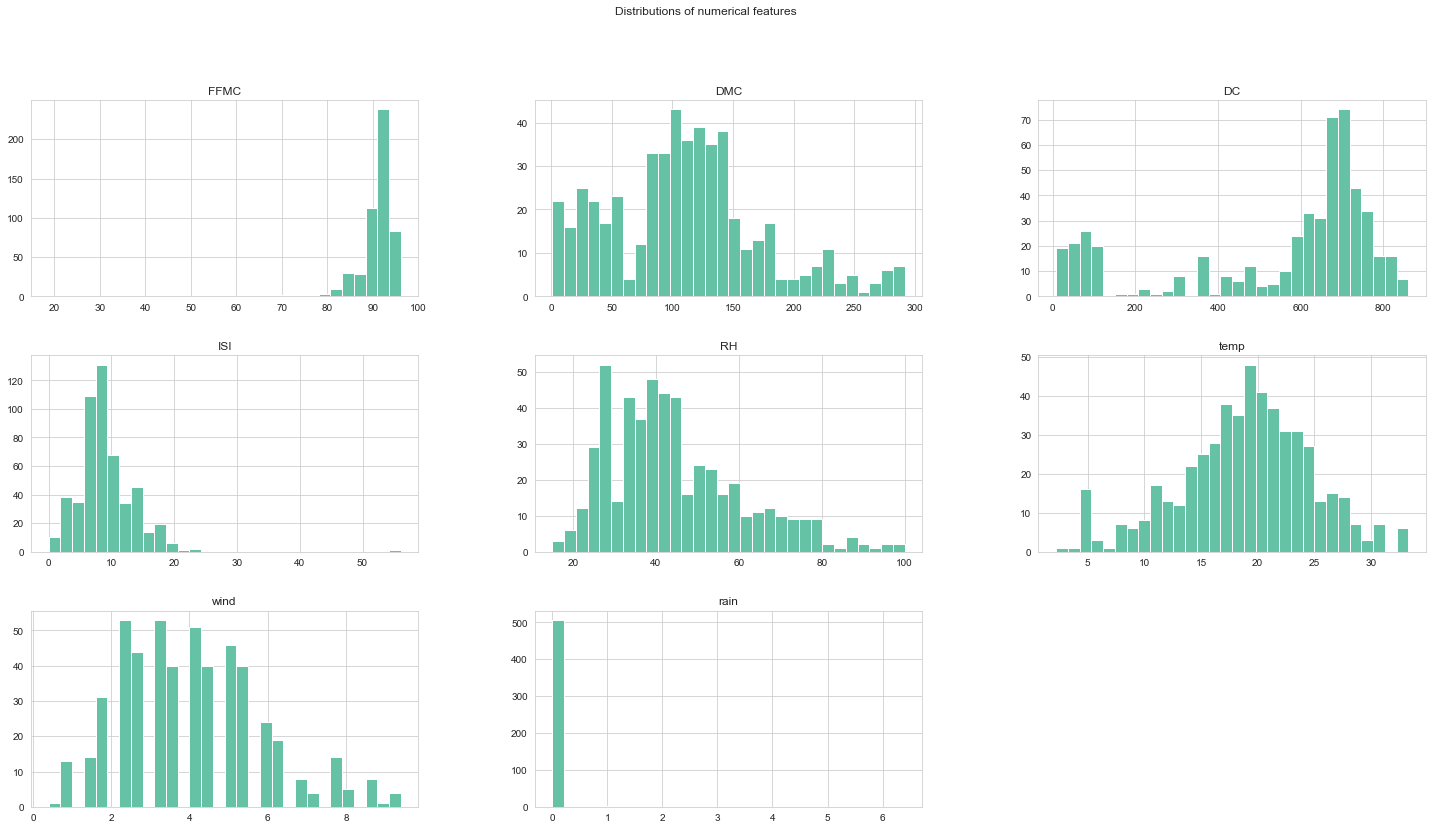

In [102]:
ax = plt.figure(figsize=(25, 13))
df[numerical_features].hist(ax=ax, bins=30)
plt.suptitle('Distributions of numerical features')
plt.show()

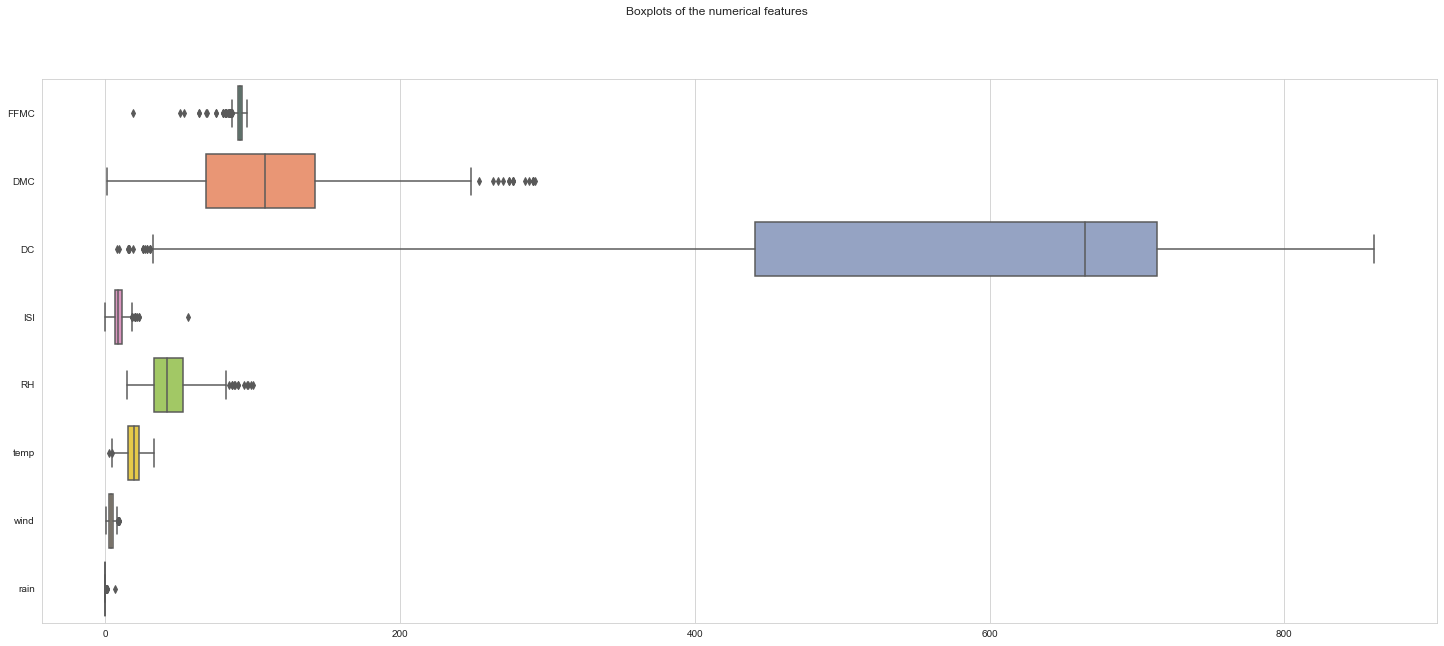

In [103]:
plt.figure(figsize=(25, 10))
sns.boxplot(data=df[numerical_features], orient='h')
plt.suptitle('Boxplots of the numerical features')
plt.show()

There are only 8 instances for which the rain attribute is greater than 0. This feature seems redundant (since it is constant for most of the data) and might cause issues when fitting the models. We should consider dropping it.

In [104]:
df.query('rain > 0').shape[0]

8

In [105]:
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [106]:
months_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
days_order = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']

In [107]:
months_vc = df['month'].value_counts()[months_order]
days_vs = df['day'].value_counts()[days_order]

We notice that most of the fires happen during the summer, and that the distribution of the number of fires across the days of the week seems almost uniform. The $\text{day}$ feature might be redundant when building the regression models.

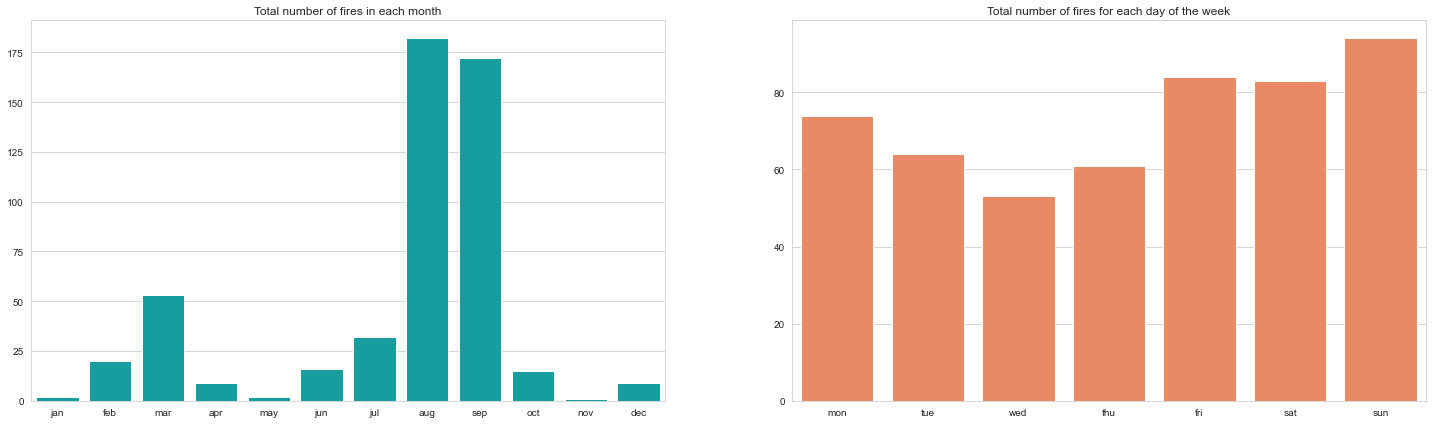

In [108]:
_, axs = plt.subplots(1, 2, figsize=(25, 7))
sns.barplot(x=months_vc.index, y=months_vc.values, ax=axs[0], color='#00B3B3')
axs[0].set_title('Total number of fires in each month')
sns.barplot(x=days_vs.index, y=days_vs.values, ax=axs[1], color='coral')
axs[1].set_title('Total number of fires for each day of the week')
plt.show()

Let's explore the distribution of the target variable

In [109]:
df['area'].describe()

count     513.000000
mean       12.891598
std        63.892586
min         0.000000
25%         0.000000
50%         0.540000
75%         6.570000
max      1090.840000
Name: area, dtype: float64

The distribution is highly skewed, and since most of the values are $0 ha$, it means that most of the fires recorded in this dataset were small in size. We will drop the entries that contain the two big outliers and perform an $\ln(x+1)$ transformation in order to address the skewness of the distribution.

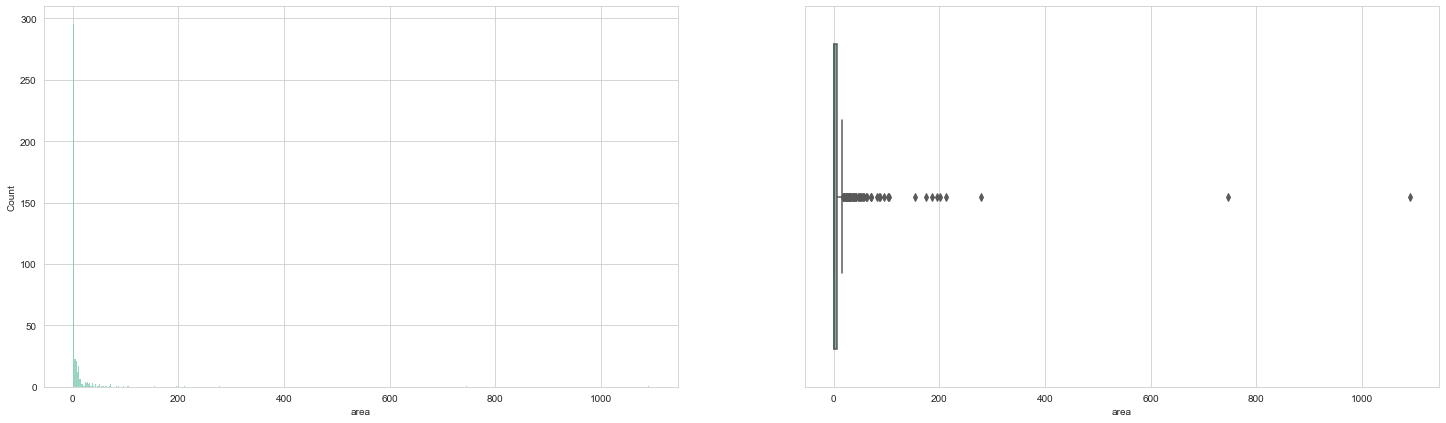

In [110]:
fig, axs = plt.subplots(1, 2, figsize=(25, 7))
sns.histplot(x=df['area'], ax=axs[0])
sns.boxplot(x=df['area'], ax=axs[1])
plt.show()

In [111]:
df.drop(df['area'].sort_values(ascending=False)[:2].index, axis=0, inplace=True)

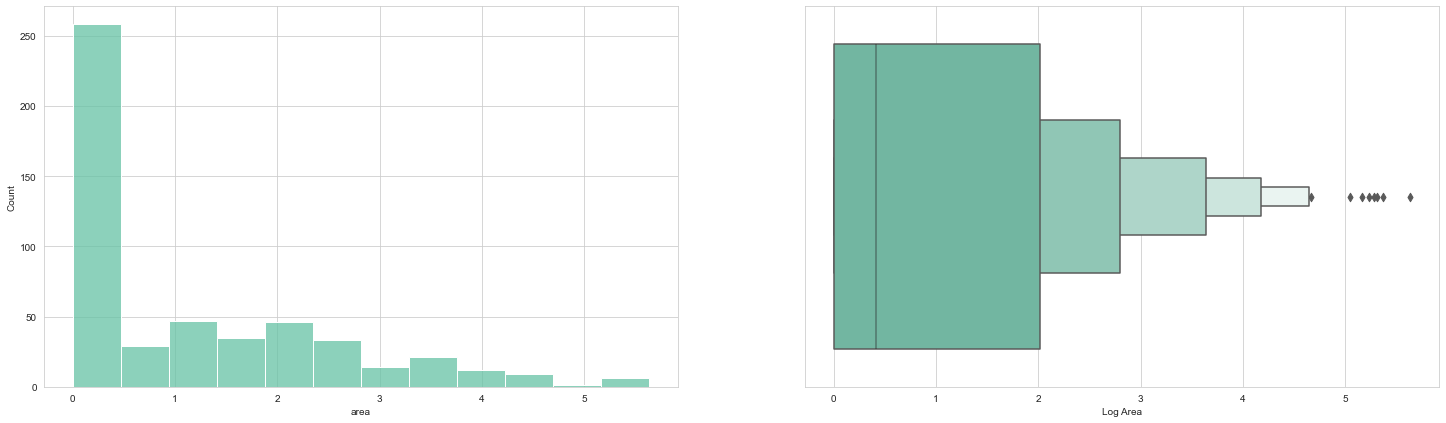

In [112]:
_, axs = plt.subplots(1, 2, figsize=(25, 7))
sns.histplot(x=np.log1p(df['area']), ax=axs[0])
sns.boxenplot(x=np.log1p(df['area']), ax=axs[1])
plt.xlabel('Log Area')
plt.show()

## 1.2 Multivariate Analysis

We observe that fires occurring in August and September result in a significant extent of burned area. Additionally, there is a notable outlier indicating a large fire that occurred in July. This feature will probably be informative when used in the regression models.

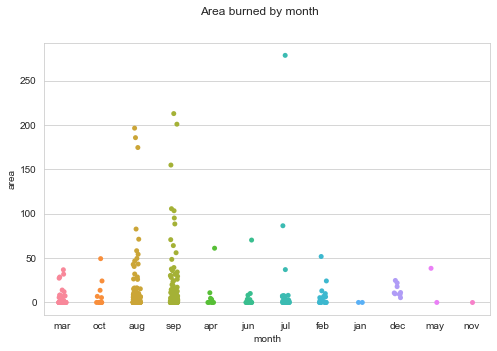

In [113]:
plt.figure(figsize=(8, 5))
plt.suptitle('Area burned by month')
sns.stripplot(data=df[['month', 'area']], x='month', y='area')
plt.show()

In [114]:
counts_by_location = (
    df.groupby(['X', 'Y'])['area']
        .count()
        .reset_index()
        .pivot(index='X', columns='Y', values='area')
).T
counts_by_location.fillna(0, inplace=True)
counts_by_location = counts_by_location.astype('int')

max_area_by_location = (
    df.groupby(['X', 'Y'])['area']
    .max()
    .reset_index()
    .pivot(index='X', columns='Y', values='area')
).T
max_area_by_location.fillna(0, inplace=True)

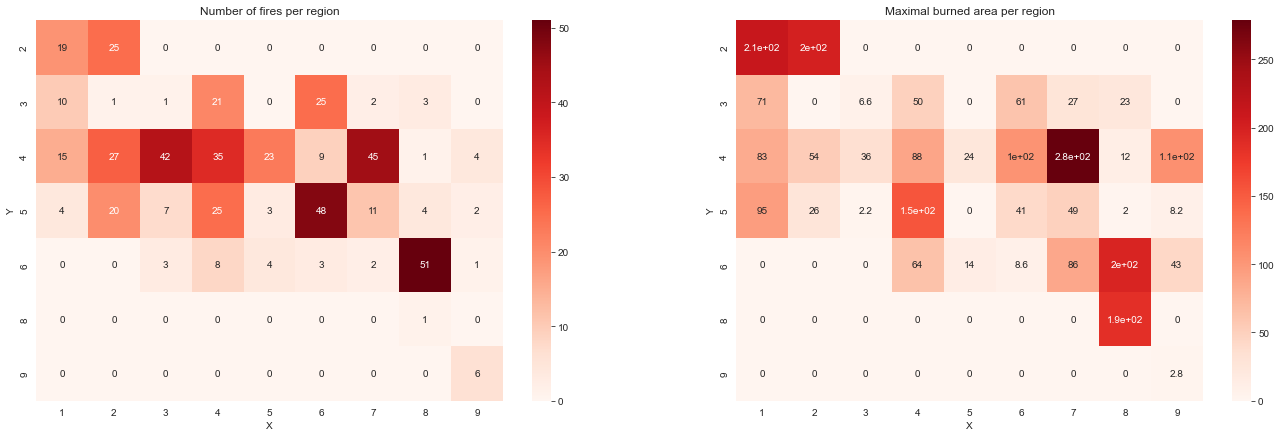

In [115]:
_, axs = plt.subplots(1, 2, figsize=(23, 7))
axs[0].set_title('Number of fires per region')
axs[1].set_title('Maximal burned area per region')
sns.heatmap(counts_by_location, vmin=0, annot=True, cmap='Reds', ax=axs[0])
sns.heatmap(max_area_by_location, vmin=0, annot=True, cmap='Reds', ax=axs[1])
plt.show()

<Figure size 1080x576 with 0 Axes>

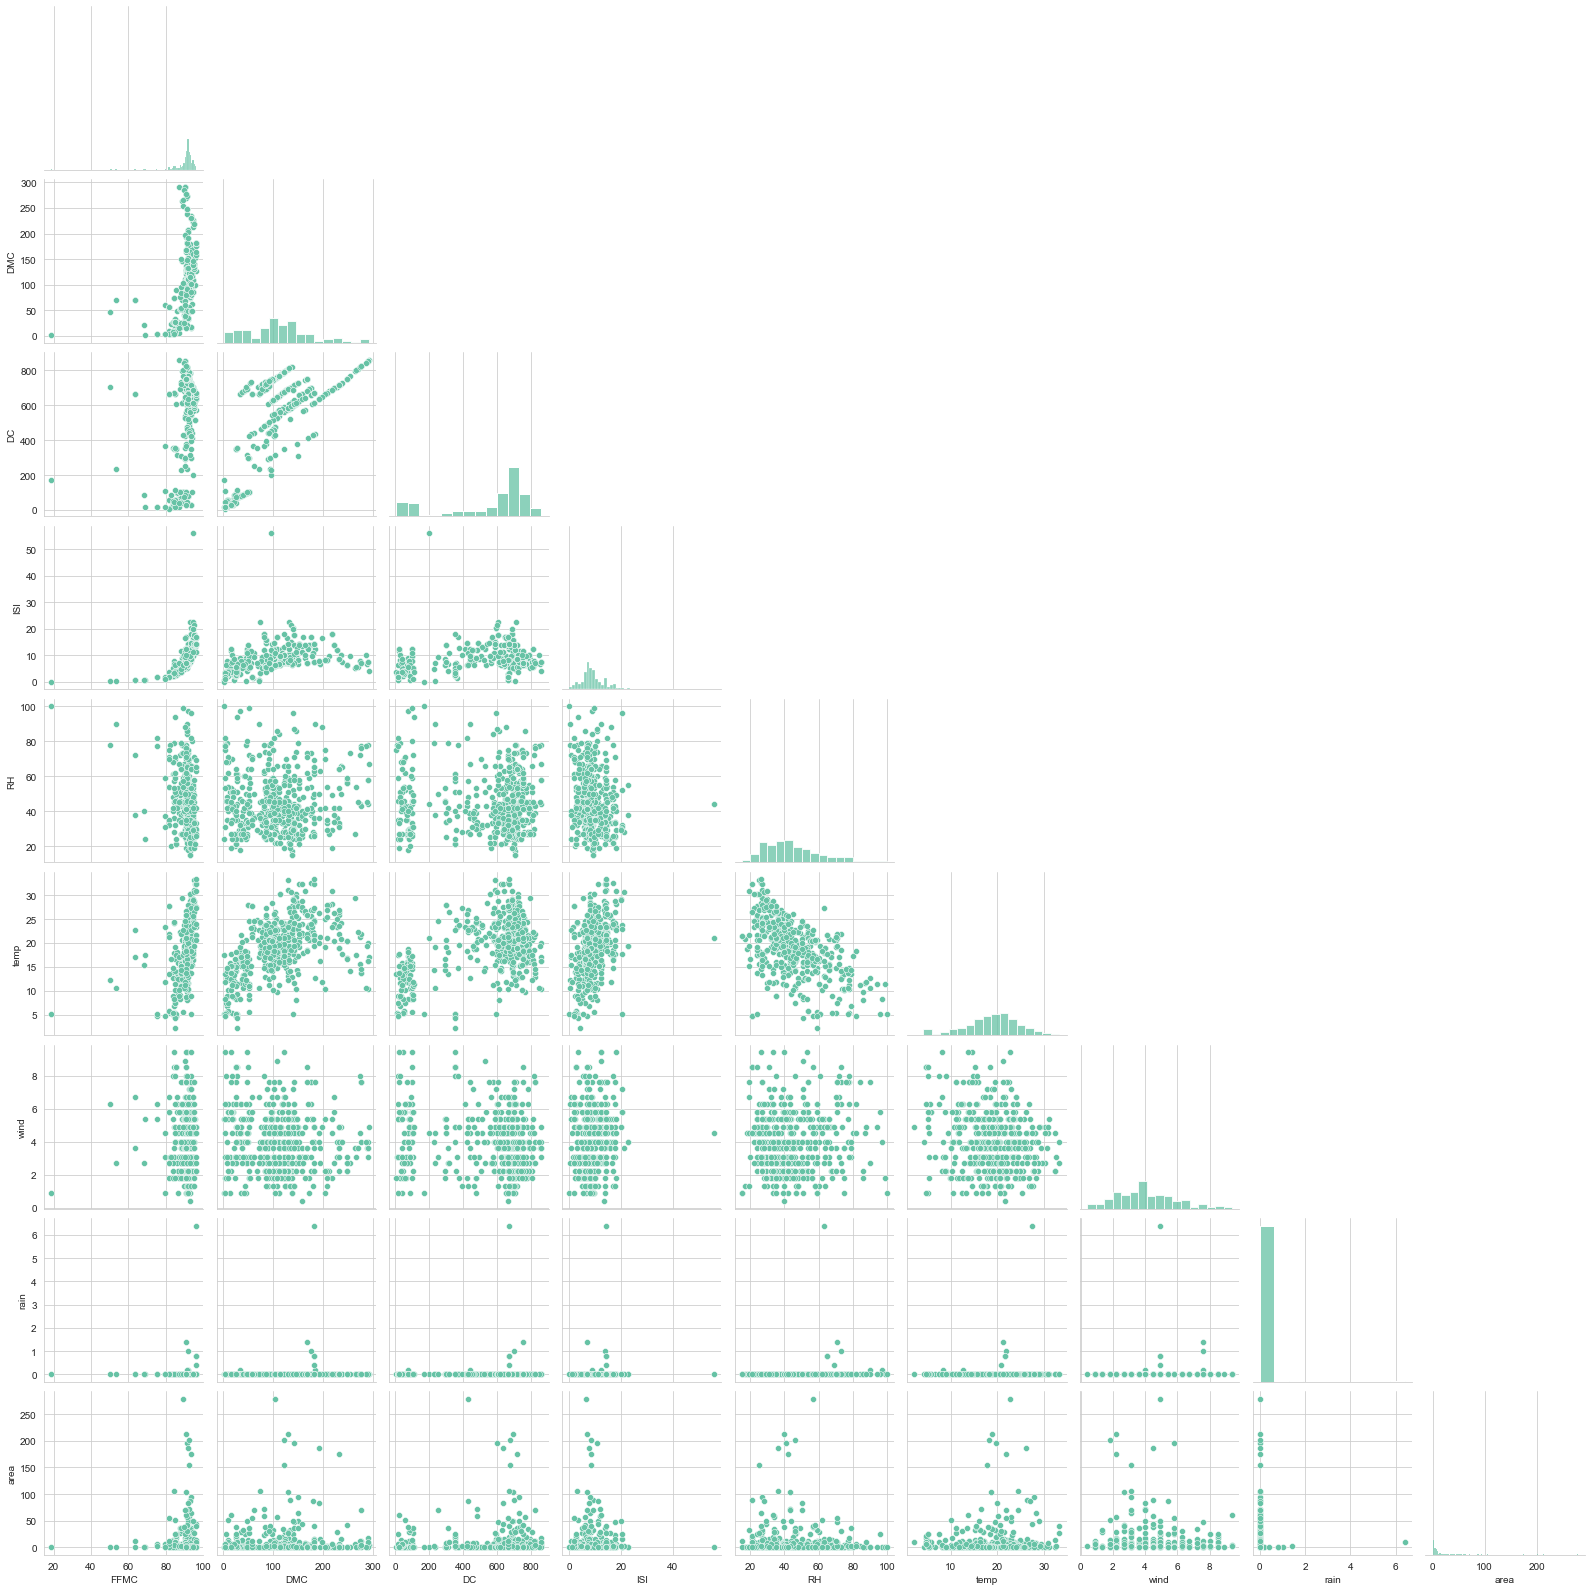

In [116]:
plt.figure(figsize=(15, 8))
sns.pairplot(df[numerical_features + ['area']], corner=True)
plt.show()

We notice relatively strong monotonic relations between the weather indices, and more importantly we notice that there is no monotonic relationship between any of the predictors and the target variable. This could potentially be a big issue when training the models.

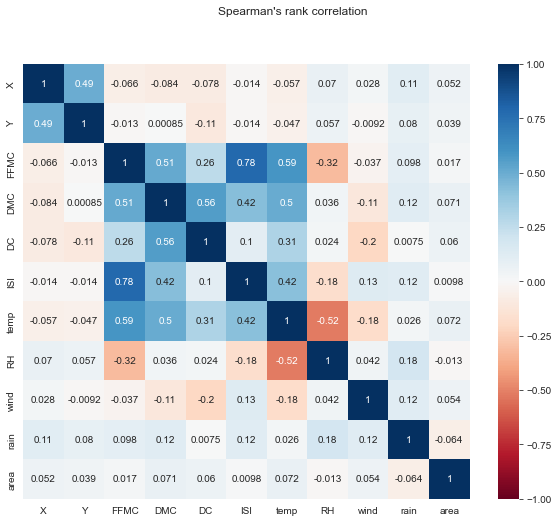

In [117]:
plt.figure(figsize=(10, 8))
plt.suptitle('Spearman\'s rank correlation')
sns.heatmap(df.corr(method='spearman'), vmin=-1, vmax=1, annot=True, cmap='RdBu')
plt.show()

Let's see the properties of the features when there are small fires (area is 0) versus when there is a bigger fire (area is above 0)

In [118]:
df['fire_type'] = pd.Series(np.where(df['area'] > 0, 'zero_area', 'positive_area'), index=df.index)

There is no notable difference in the distributions for the numerical features
(Note that in a KDE plot, the plot may extend beyond the range of a certain variable, such as the "rain" attribute. Even though the "rain" attribute does not have values below 0, the KDE plot still displays a non-zero density in that region).

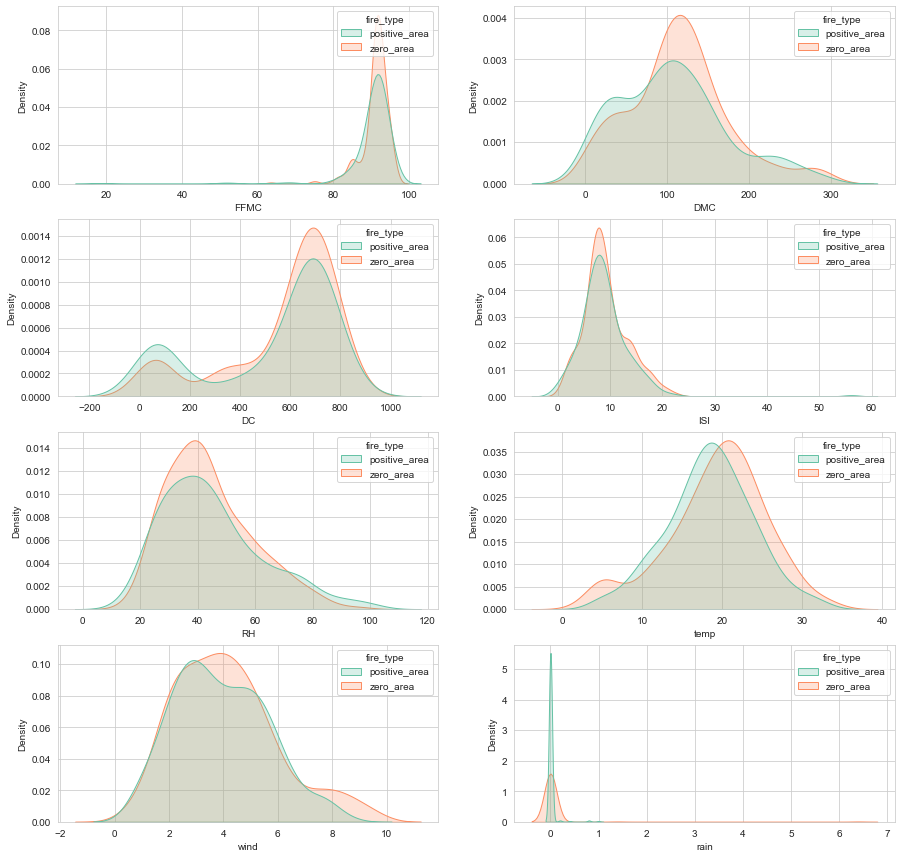

In [119]:
_, axs = plt.subplots(4, 2, figsize=(15, 15))
axis = [(i, j) for i in range(4) for j in range(2)]
k = 0

for feature in numerical_features:
    i, j = axis[k]
    sns.kdeplot(x=df[feature], hue=df['fire_type'], shade=True, ax=axs[i][j])
    k += 1

In [120]:
fires_by_month_and_type = (
    df.groupby(['month', 'fire_type'])['X']
    .count()[months_order]
    .reset_index()
)
fires_by_month_and_type.columns = ['month', 'fire_type', 'count']

We observe similar results for the month feature as well.

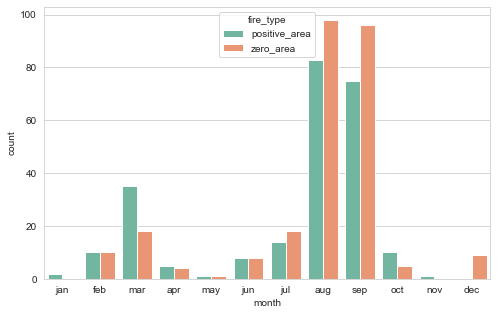

In [121]:
plt.figure(figsize=(8, 5))
sns.barplot(x=fires_by_month_and_type['month'], y=fires_by_month_and_type['count'], hue=fires_by_month_and_type['fire_type'])
plt.show()

In [122]:
df.drop('fire_type', axis=1, inplace=True)

# 2. Splitting the dataset

In [123]:
from sklearn.model_selection import train_test_split

In [124]:
y = df['area'].copy()
X = df.drop('area', axis=1, inplace=False).copy()

Due to the relatively small size of the dataset, we will convert the target variable into discrete categories to enable a stratified split.

In [125]:
y_bins = np.array([0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 6.0, 10.0, 50.0, 150.0, 200.0])
y_binned = np.digitize(y, y_bins)

In [126]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.8, stratify=y_binned, random_state=22)

In [127]:
print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)

(408, 12) (103, 12) (408,) (103,)


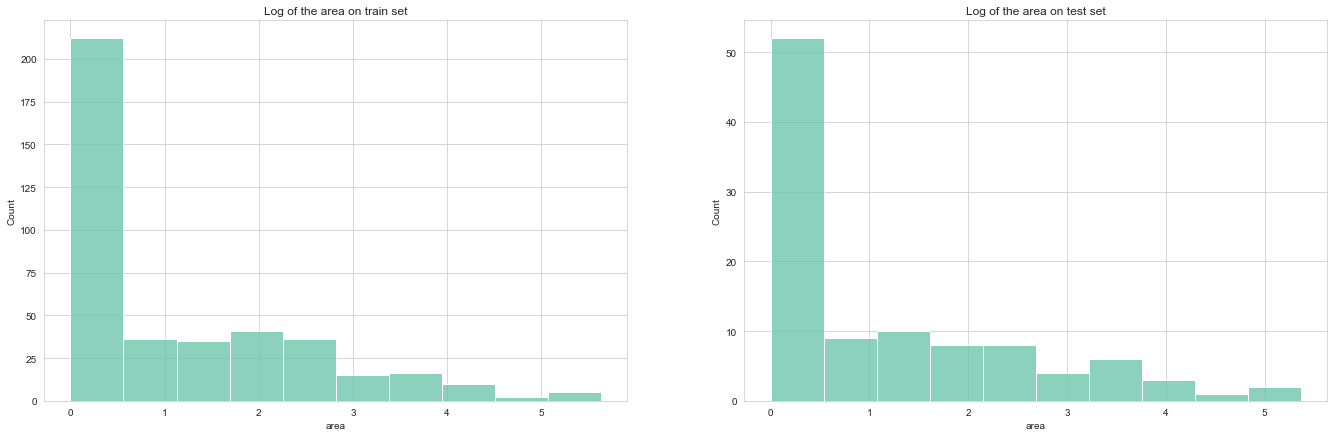

In [128]:
_, axs = plt.subplots(1, 2, figsize=(23, 7))
axs[0].set_title('Log of the area on train set')
axs[1].set_title('Log of the area on test set')
sns.histplot(x=np.log1p(train_y), ax=axs[0], bins=10)
sns.histplot(x=np.log1p(test_y), ax=axs[1], bins=10)
plt.show()

# 3. Feature transformations & Scaling

In [129]:
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, StandardScaler

In [130]:
# dropping the rain and day columns
train_X.drop(['rain', 'day'], axis=1, inplace=True)
test_X.drop(['rain', 'day'], axis=1, inplace=True)

In [131]:
# encoding month with OrdinalEncoder
ordinal_encoder = OrdinalEncoder(categories=[months_order])
train_X['month'] = ordinal_encoder.fit_transform(train_X[['month']])
test_X['month'] = ordinal_encoder.transform(test_X[['month']])

In [132]:
minmax_scaler = MinMaxScaler()
train_X = pd.DataFrame(minmax_scaler.fit_transform(train_X), index=train_X.index, columns=train_X.columns)
test_X = pd.DataFrame(minmax_scaler.transform(test_X), index=test_X.index, columns=test_X.columns)

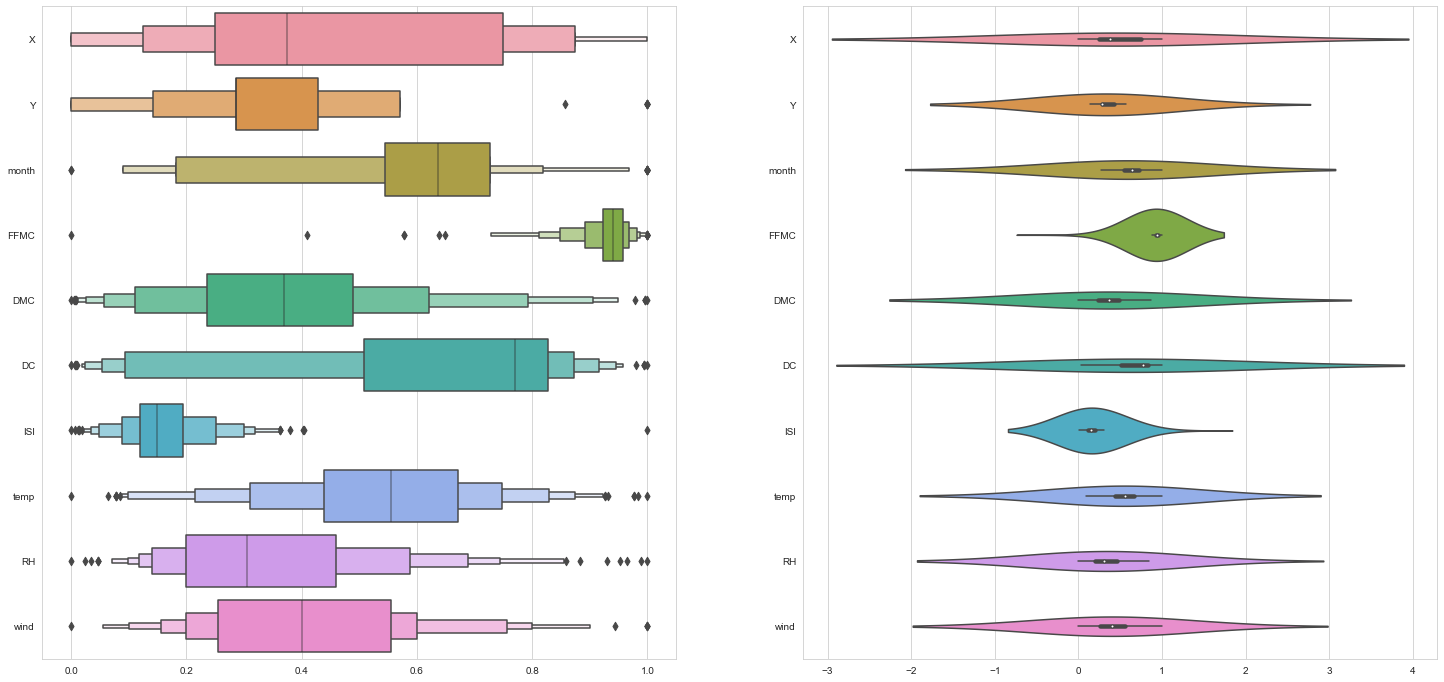

In [133]:
_, axs = plt.subplots(1, 2, figsize=(25, 12))
sns.boxenplot(data=train_X, orient='h', ax=axs[0])
sns.violinplot(data=train_X, bw=5, orient='h', ax=axs[1])
plt.show()

Applying the log transform

In [134]:
function_transformer = FunctionTransformer(func=np.log1p)

train_y = pd.Series(function_transformer.fit_transform(train_y), index=train_y.index)
test_y = pd.Series(function_transformer.transform(test_y), index=test_y.index)

# 4. Feature Engineering

We can try clustering the data and using the results as a new feature in the dataset. Maybe we can find the latent factor that makes half of the entries have area 0 and the rest half of the entries area that is different from 0.

In [135]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [136]:
train_X_unscaled = pd.DataFrame(minmax_scaler.inverse_transform(train_X), index=train_X.index, columns=train_X.columns)

standard_scaler = StandardScaler()
train_X_standardized = pd.DataFrame(standard_scaler.fit_transform(train_X_unscaled), index=train_X.index, columns=train_X.columns)

In [137]:
pca = PCA(n_components=2, random_state=23)
pca_df = pd.DataFrame(pca.fit_transform(train_X_standardized), index=train_X.index)

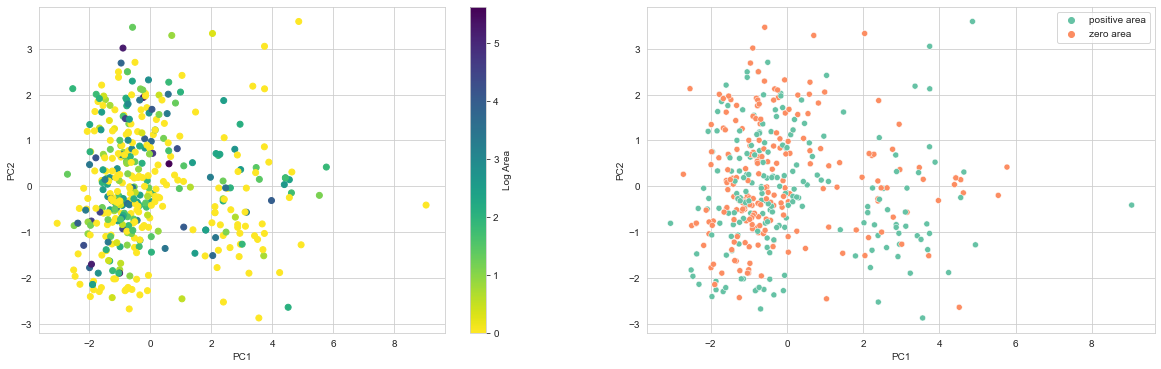

In [138]:
_, axs = plt.subplots(1, 2, figsize=(20, 6))
scatter = axs[0].scatter(pca_df[0], pca_df[1], c=train_y, cmap='viridis_r')
sns.scatterplot(x=pca_df[0], y=pca_df[1], hue=pd.Series(np.where(train_y > 0, 'zero area', 'positive area'), index=train_y.index), ax=axs[1])
cbar = fig.colorbar(scatter, ax=axs[0])
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC2')
cbar.set_label('Log Area')
plt.show()

## 4.1 K-Means Clustering

In [139]:
SSE = list()
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, random_state=22)
    kmeans.fit(train_X)
    SSE.append(kmeans.inertia_)

In [140]:
kmeans = KMeans(n_clusters=2, random_state=22).fit(train_X)
clusters = pd.Series(kmeans.labels_, index=train_X.index)

This clustering does not capture the reason why some of the fires were "small" and some "big"

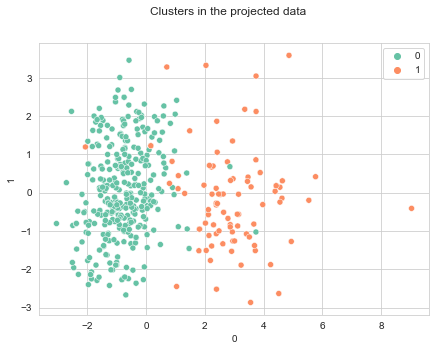

In [141]:
plt.figure(figsize=(7, 5))
plt.suptitle('Clusters in the projected data')
sns.scatterplot(x=pca_df[0], y=pca_df[1], hue=clusters)
plt.show()

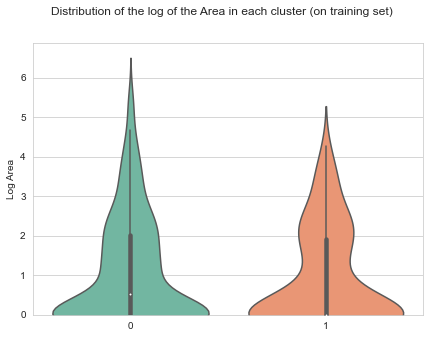

In [142]:
plt.figure(figsize=(7, 5))
sns.violinplot(x=pd.Series(kmeans.predict(train_X), index=train_X.index), y=train_y)
plt.ylabel('Log Area')
plt.ylim(0)
plt.suptitle('Distribution of the log of the Area in each cluster (on training set)')
plt.show()

## 4.2 Hierarchical Clustering

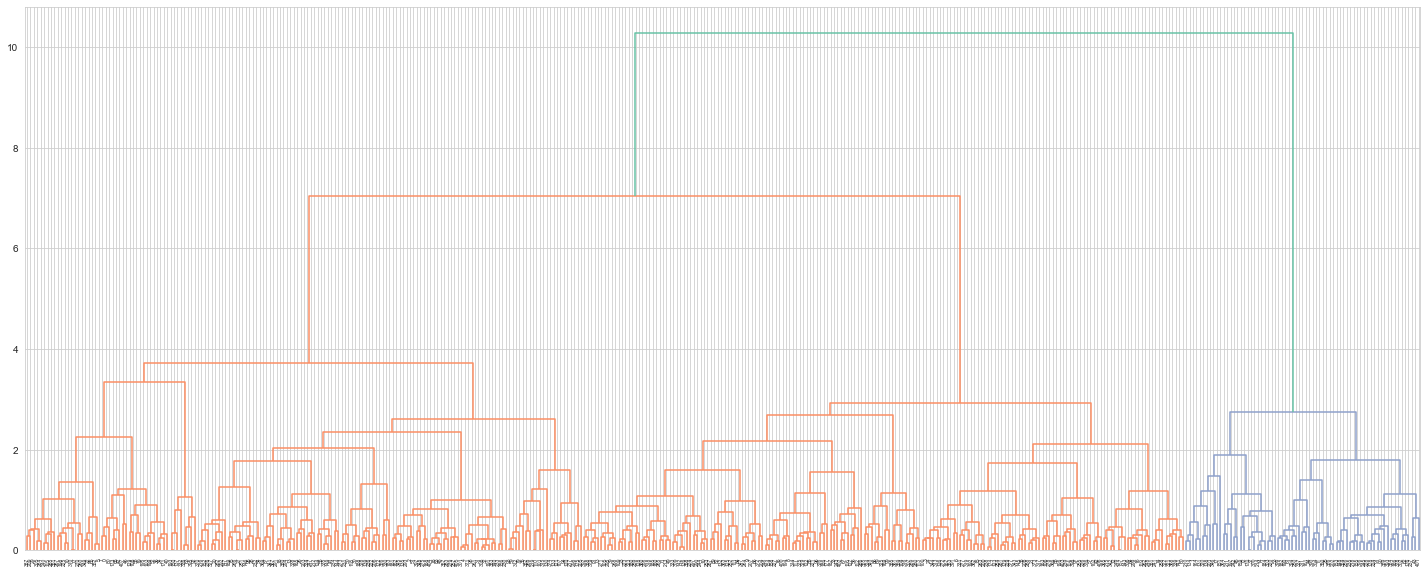

In [143]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering

# Ward was chosen because of noise and outliers
linked = linkage(train_X, 'ward')

plt.figure(figsize=(25, 10))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=False)
plt.show()

In [144]:
ac_2 = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
ac_3 = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')

labels_ac_2 = pd.Series(ac_2.fit_predict(train_X), index=train_X.index)
labels_ac_3 = pd.Series(ac_3.fit_predict(train_X), index=train_X.index)

This clustering just like KMeans, failed to capture the relationship between datapoints that have positive and datapoints that have zero area burned.

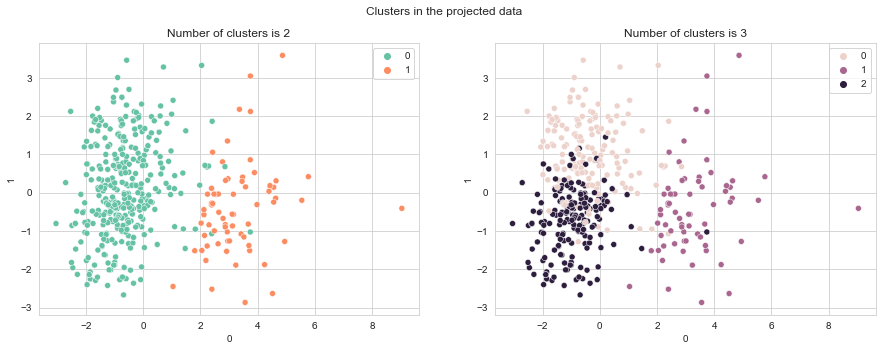

In [145]:
_, axs = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle('Clusters in the projected data')
sns.scatterplot(x=pca_df[0], y=pca_df[1], hue=labels_ac_2, ax=axs[0])
axs[0].set_title('Number of clusters is 2')
sns.scatterplot(x=pca_df[0], y=pca_df[1], hue=labels_ac_3, ax=axs[1])
axs[1].set_title('Number of clusters is 3')
plt.show()

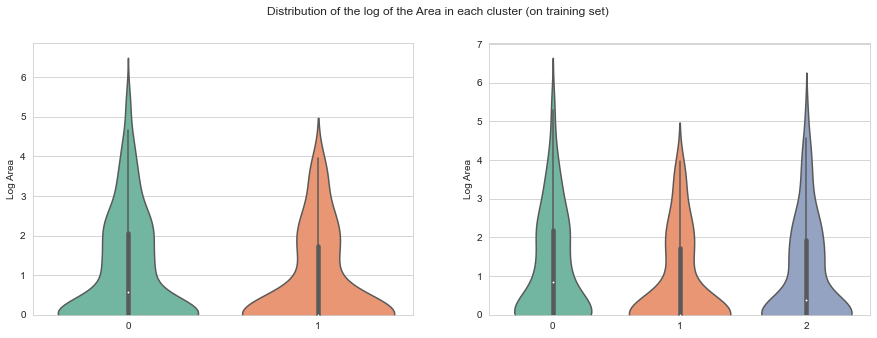

In [146]:
_, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.violinplot(x=labels_ac_2, y=train_y, ax=axs[0])
sns.violinplot(x=labels_ac_3, y=train_y, ax=axs[1])
axs[0].set_ylabel('Log Area')
axs[0].set_ylim(0)
axs[1].set_ylabel('Log Area')
axs[1].set_ylim(0)
plt.suptitle('Distribution of the log of the Area in each cluster (on training set)')
plt.show()

We will not use the results of the clustering in the feature engineering step, to reduce the risk of adding a redundant feature.

<i> Utility methods</i>

In [147]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score, mean_squared_error

results = dict()

def plot_residuals(test_y, pred_y):
    residuals = test_y - pred_y.reshape(-1)
    fig, axs = plt.subplots(1, 2, figsize=(20, 5))
    sns.histplot(x=residuals, ax=axs[0])
    axs[0].axvline(x=0, color='r')
    axs[0].axvline(x=np.mean(np.array(residuals)), color='blue')
    axs[0].set_xlabel('Log Area')
    sns.boxplot(x=residuals, ax=axs[1])
    axs[1].set_xlabel('Log Area')

def print_ture_vs_predicted(test_y, pred_y):
    plt.figure(figsize=(7, 4))
    sns.scatterplot(x=test_y, y=pred_y)
    x = list(range(-10, 25))
    sns.lineplot(x=x, y=x, color='red')
    plt.suptitle('Predicted values vs True values')
    plt.xlabel('true area')
    plt.ylabel('predicted area')
    plt.ylim(-0.3, 5)
    plt.xlim(-0.3, 6)
    plt.show()

def print_results(test_y, pred_y):
    r2, rmse = get_results(test_y, pred_y)
    print(f'  R2: {r2}')
    print(f'RMSE: {rmse}')

def get_results(test_y, pred_y):
    return r2_score(test_y, pred_y), mean_squared_error(test_y, pred_y, squared=False)

# 5. Linear Regression

In [148]:
lr = LinearRegression()
lr.fit(train_X, train_y)
lr_pred_y = lr.predict(test_X)

The residuals are skewed which is not desired. Ideally this distribution would be symmetric and centered around 0

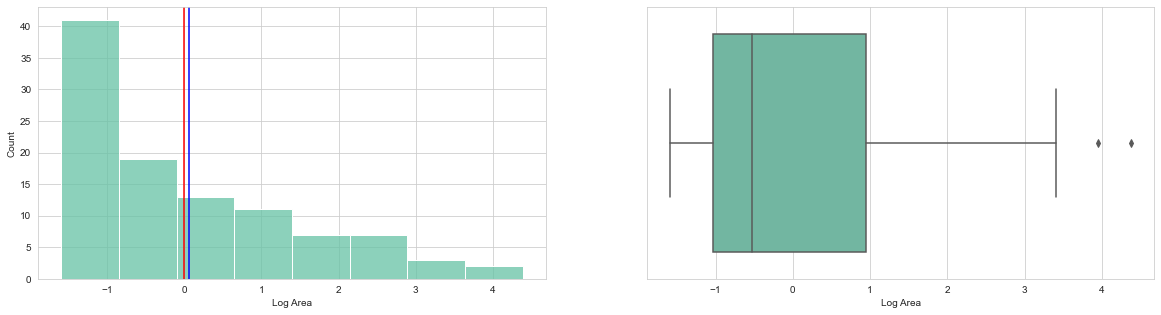

In [149]:
plot_residuals(test_y, lr_pred_y)

Ideally we would like the data to be very close to the red line (on the plot below).

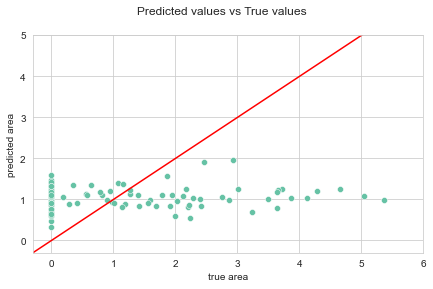

In [150]:
print_ture_vs_predicted(test_y, lr_pred_y)

In [151]:
test_y.describe()

count    103.000000
mean       1.121391
std        1.407458
min        0.000000
25%        0.000000
50%        0.418710
75%        2.009498
max        5.365415
Name: area, dtype: float64

The model seems to be off by one standard deviation on average.

In [152]:
print_results(test_y, lr_pred_y)

  R2: -0.016305315085994643
RMSE: 1.4119812005102053


In [153]:
pd.Series(lr.coef_, index=train_X.columns, name='weight')

X        0.342257
Y        0.066398
month    1.751503
FFMC     0.326880
DMC      0.460078
DC      -0.972495
ISI     -2.066424
temp     0.676172
RH       0.121079
wind     0.459501
Name: weight, dtype: float64

In [154]:
results.setdefault('lr', []).extend(list(get_results(test_y, lr_pred_y)))

# 6. Lasso Regression
We will use polynomial basis function expansion hoping that the data would be better represented in a higher dimensional space. Using a sparsity promoting prior (such as L1 regularization) is appropriate in this case, since we will be working with a greater number of fetures.

In [155]:
from sklearn.preprocessing import PolynomialFeatures

In [156]:
poly = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)

train_X_poly = poly.fit_transform(train_X)
test_X_poly = poly.transform(test_X)

In [157]:
print(train_X_poly.shape, test_X_poly.shape)

(408, 285) (103, 285)


In [158]:
lasso_lr = Lasso()
lasso_lr.fit(train_X_poly, train_y)
lasso_pred_y = lasso_lr.predict(test_X_poly)

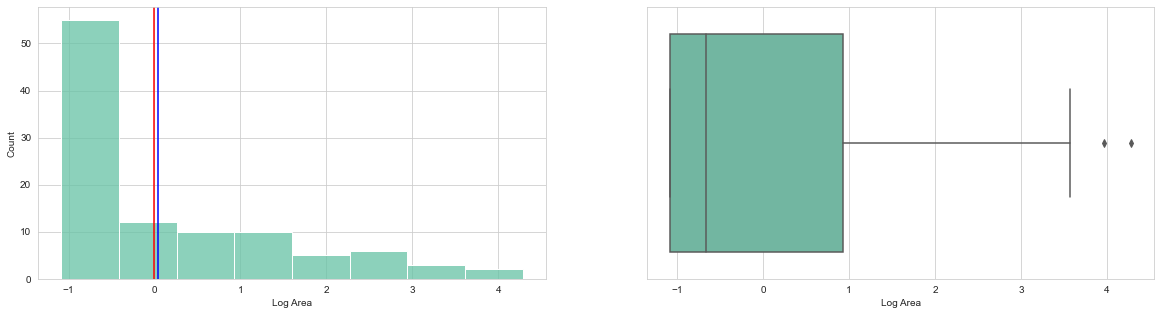

In [159]:
plot_residuals(test_y, lasso_pred_y)

In [160]:
lasso_lr.intercept_

1.0830763702313988

All the weights (except the bias) are 0. The model simply predicts the mean of the area.

In [161]:
np.sum(lasso_lr.coef_ > 0)

0

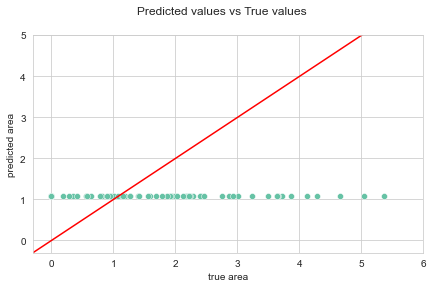

In [162]:
print_ture_vs_predicted(test_y, lasso_pred_y)

In [163]:
print_results(test_y, lasso_pred_y)

  R2: -0.0007483455322601085
RMSE: 1.401132659794714


In [164]:
results.setdefault('lasso', []).extend(list(get_results(test_y, lasso_pred_y)))

# 7. Random Forest

In [165]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [166]:
params = dict(n_estimators=[100, 130, 150], max_depth=[5, 7, 9], min_samples_split=[40, 50, 70], criterion=['squared_error', 'absolute_error'])

rf = RandomForestRegressor(random_state=42, n_jobs=-1)
skf = StratifiedKFold(5, shuffle=True, random_state=23)
grid_search = GridSearchCV(rf, params, cv=3, n_jobs=-1)
grid_search.fit(train_X, train_y)

GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'absolute_error'],
                         'max_depth': [5, 7, 9],
                         'min_samples_split': [40, 50, 70],
                         'n_estimators': [100, 130, 150]})

In [167]:
grid_search.best_score_

-0.011371455583668255

In [168]:
grid_search.best_params_

{'criterion': 'squared_error',
 'max_depth': 5,
 'min_samples_split': 70,
 'n_estimators': 150}

In [169]:
rf = grid_search.best_estimator_

In [170]:
rf_pred_y = rf.predict(test_X)

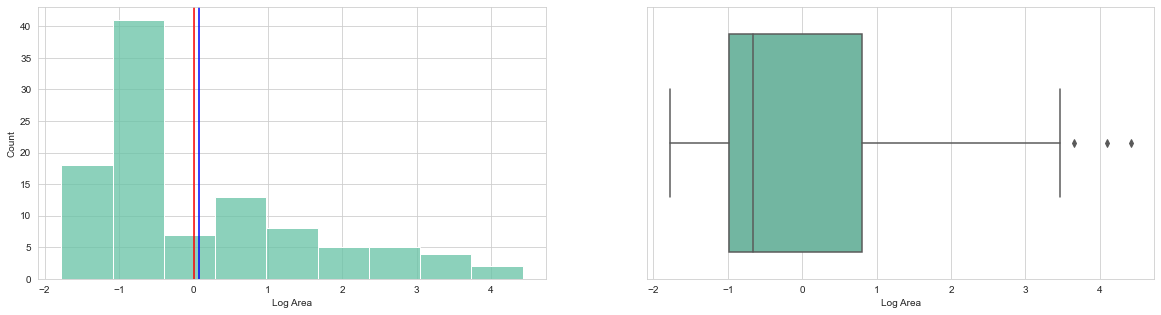

In [171]:
plot_residuals(test_y, rf_pred_y)

In [172]:
print('Results on Train set:')
print_results(train_y, rf.predict(train_X))
print('\nResults on Test set:')
print_results(test_y, rf_pred_y)

Results on Train set:
  R2: 0.1656453080735122
RMSE: 1.2242281420096373

Results on Test set:
  R2: -0.05156683535415585
RMSE: 1.436267245515844


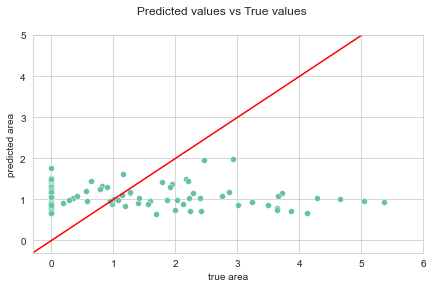

In [173]:
print_ture_vs_predicted(test_y, rf_pred_y)

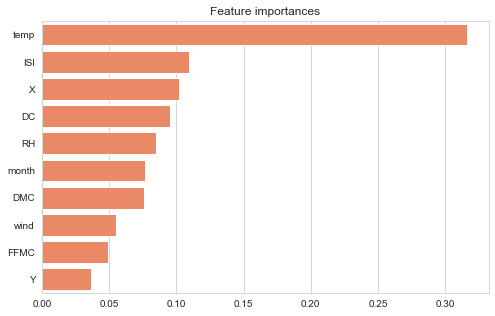

In [174]:
plt.figure(figsize=(8, 5))
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
names = [train_X.columns[i] for i in indices]
sns.barplot(x=importances[indices], y=names, color='coral')
plt.title('Feature importances')
plt.show()

In [175]:
results.setdefault('rf', []).extend(list(get_results(test_y, rf_pred_y)))

# 8. MLP

In [176]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import tensorflow as tf

In [177]:
MLP = Sequential([
    Dense(units=32, activation='sigmoid', input_shape=[len(train_X.columns)]),
    BatchNormalization(),
    Dense(units=16, activation='sigmoid'),
    BatchNormalization(),
    Dense(units=1, activation='linear'),
])

In [178]:
MLP.compile(
    loss='mean_squared_error',
    optimizer=Adam(learning_rate=0.001),
    metrics=['mae']
)

In [179]:
tf.random.set_seed(123)
history = MLP.fit(
    x=train_X,
    y=train_y,
    validation_split=0.15,
    batch_size=8,
    epochs=50,
    shuffle=False,
    verbose=1,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    ]
)

Epoch 1/50
44/44 [==============================] - 1s 8ms/step - loss: 2.9803 - mae: 1.2292 - val_loss: 2.3318 - val_mae: 1.1278
Epoch 2/50
44/44 [==============================] - 0s 4ms/step - loss: 2.5183 - mae: 1.0896 - val_loss: 2.2718 - val_mae: 1.1352
Epoch 3/50
44/44 [==============================] - 0s 3ms/step - loss: 2.2655 - mae: 1.0528 - val_loss: 2.2068 - val_mae: 1.1446
Epoch 4/50
44/44 [==============================] - 0s 3ms/step - loss: 2.0683 - mae: 1.0352 - val_loss: 2.1487 - val_mae: 1.1567
Epoch 5/50
44/44 [==============================] - 0s 3ms/step - loss: 1.9166 - mae: 1.0251 - val_loss: 2.1021 - val_mae: 1.1680
Epoch 6/50
44/44 [==============================] - 0s 3ms/step - loss: 1.8043 - mae: 1.0178 - val_loss: 2.0676 - val_mae: 1.1798
Epoch 7/50
44/44 [==============================] - 0s 3ms/step - loss: 1.7255 - mae: 1.0147 - val_loss: 2.0432 - val_mae: 1.1888
Epoch 8/50
44/44 [==============================] - 0s 3ms/step - loss: 1.6719 - mae: 1.01

In [180]:
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,mae,val_loss,val_mae
0,2.980345,1.229178,2.331751,1.127799
1,2.518271,1.089603,2.271845,1.135225
2,2.265465,1.052843,2.206811,1.144593
3,2.068334,1.035166,2.148675,1.156674
4,1.916631,1.025120,2.102054,1.168022


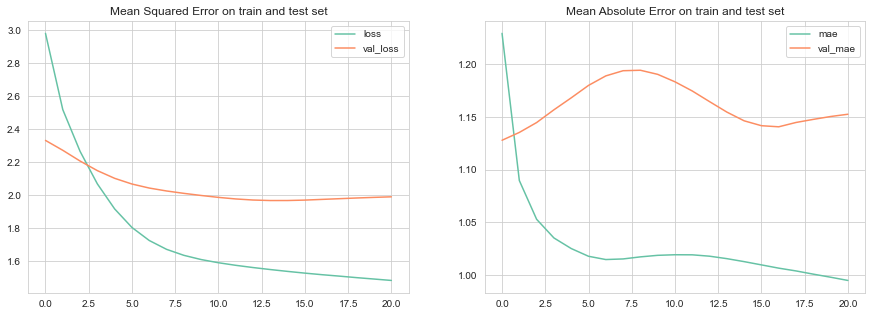

In [181]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].set_title('Mean Squared Error on train and test set')
axs[1].set_title('Mean Absolute Error on train and test set')
history_df.loc[:, ['loss', 'val_loss']].plot(ax=axs[0])
history_df.loc[:, ['mae', 'val_mae']].plot(ax=axs[1])
plt.show()

In [182]:
mlp_pred_y = np.squeeze(MLP.predict(test_X))

4/4 [==============================] - 0s 3ms/step


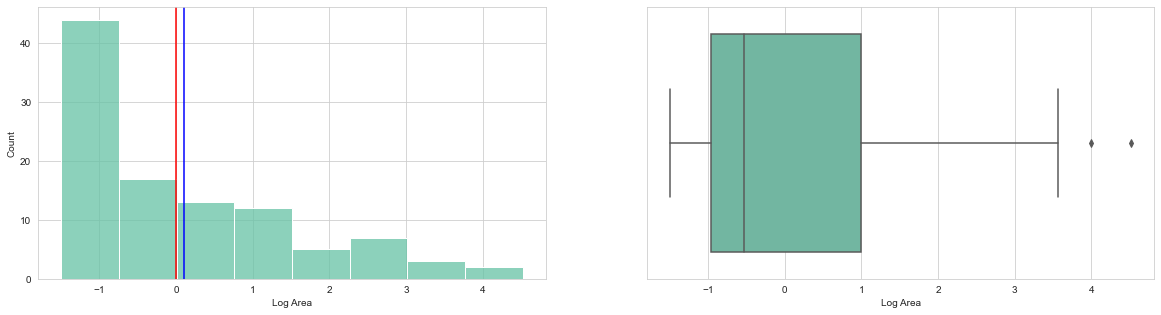

In [183]:
plot_residuals(test_y, mlp_pred_y)

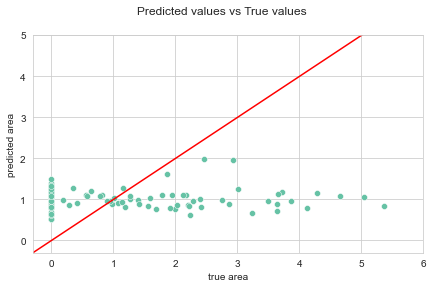

In [184]:
print_ture_vs_predicted(test_y, np.squeeze(mlp_pred_y))

In [185]:
print_results(test_y, mlp_pred_y)

  R2: -0.026824613943920994
RMSE: 1.419269765963174


In [186]:
results.setdefault('mlp', []).extend(list(get_results(test_y, rf_pred_y)))

# Results

In [187]:
results = pd.DataFrame(results, index=['r2', 'mse']).reset_index()
results.columns = ['metric'] + list(results.columns[1:])
results = pd.melt(results, id_vars='metric', var_name='model', value_name='value')

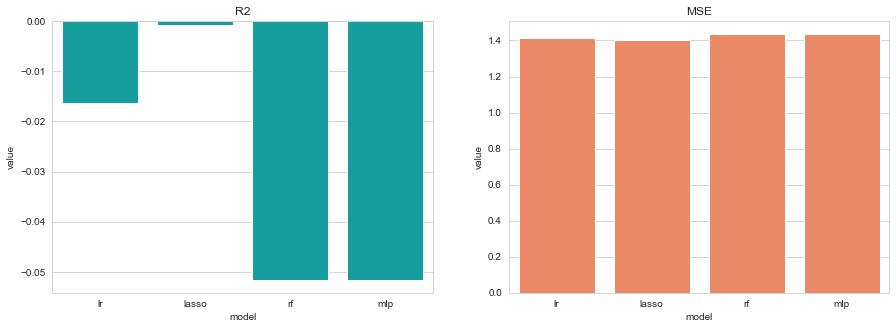

In [188]:
_, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(data=results.query('metric == "r2"'), x='model', y='value', color='#00B3B3', ax=axs[0])
sns.barplot(data=results.query('metric == "mse"'), x='model', y='value', color='coral', ax=axs[1])
axs[0].set_title('R2')
axs[1].set_title('MSE')
plt.show()

After extensive analysis using different models, it became clear that predicting the burned area in the Montesinho Park forest posed significant challenges. Surprisingly, all the models performed worse than a simple approach of using the mean of the target attribute for predictions.
It is likely the case that that important variables or interactions might be missing from the dataset, limiting our ability to accurately predict the burned area.